In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import nibabel as nib

In [3]:
import dipy.core.gradients as dpg

In [4]:
import AFQ.data as afd
import AFQ.registration as reg

In [5]:
import configparser

In [6]:
import os.path as op

In [7]:
CP = configparser.ConfigParser()
CP.read_file(open(op.join(op.expanduser('~'), '.aws', 'credentials')))
CP.sections()
ak = CP.get('hcp', 'AWS_ACCESS_KEY_ID')
sk = CP.get('hcp', 'AWS_SECRET_ACCESS_KEY')

In [8]:
import boto3

In [9]:
from dki_dipy import get_credentials, rmse

In [10]:
ak, sk = get_credentials()

In [11]:
session = boto3.session.Session(aws_access_key_id=ak, aws_secret_access_key=sk)

In [12]:
subject = 100307

In [13]:
files = afd.fetch_hcp([100307])

In [14]:
stub = op.join(afd.afq_home, "HCP", "derivatives", "preafq", "sub-%s"%subject, "sess-01", "dwi", "sub-%s_dwi"%subject)

In [15]:
gtab = dpg.gradient_table(stub + ".bval", stub+".bvec", b0_threshold=10)

In [16]:
img = nib.load(stub + ".nii.gz")

In [17]:
dwi = img.get_data()

In [151]:
b0 = np.mean(dwi[..., gtab.b0s_mask], -1)

In [18]:
seg = nib.load(op.join(afd.afq_home, "HCP", "derivatives", "preafq", "sub-%s"%subject, "sess-01", "anat",
                       "sub-%s_aparc+aseg.nii.gz"%subject))

In [19]:
seg_data_orig = seg.get_data()

In [20]:
wm_labels = [250, 251, 252, 253, 254, 255, 41, 2, 16, 77]

In [21]:
seg_data_orig = np.sum(np.concatenate([(seg_data_orig == l)[..., None] for l in wm_labels], -1), -1)

In [22]:
wm_mask_xform = np.round(reg.resample(seg_data_orig, dwi[..., 0], seg.affine, img.affine)).astype(int)

In [23]:
from dipy.reconst import dti

In [24]:
dtm = dti.TensorModel(gtab)

In [25]:
dtf = dtm.fit(dwi, mask=wm_mask_xform)

In [26]:
dti_pred = dtf.predict(gtab, np.mean(dwi[..., gtab.b0s_mask], -1))

/Users/arokem/source/dipy/dipy/reconst/dti.py:1913: RuntimeWarning: divide by zero encountered in log
  D[..., 6] = -np.log(b0)


In [27]:
rmse_dti = rmse(dti_pred[wm_mask_xform == 1], dwi[wm_mask_xform == 1])

In [28]:
rmse_dti_map = np.ones(wm_mask_xform.shape) * np.nan

In [29]:
rmse_dti_map[wm_mask_xform == 1] = rmse_dti

In [30]:
from dipy.reconst import dki

In [31]:
dkm = dki.DiffusionKurtosisModel(gtab)

In [32]:
dkf = dkm.fit(dwi, mask=wm_mask_xform)

In [33]:
dki_pred = dkf.predict(gtab, np.mean(dwi[..., gtab.b0s_mask], -1))

/Users/arokem/source/dipy/dipy/reconst/dki.py:1263: RuntimeWarning: divide by zero encountered in log
  np.array([np.log(this_S0)])),


In [34]:
rmse_dki = rmse(dki_pred[wm_mask_xform == 1], dwi[wm_mask_xform == 1])

In [35]:
rmse_dki_map = np.ones(wm_mask_xform.shape) * np.nan

In [36]:
rmse_dki_map[wm_mask_xform == 1] = rmse_dki

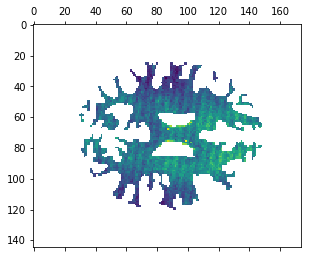

In [37]:
plt.matshow(rmse_dki_map[..., rmse_dki_map.shape[-1]//2])

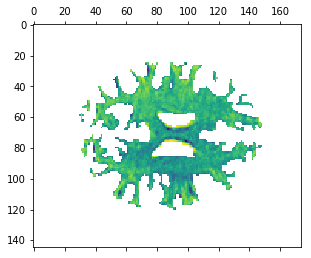

In [42]:
plt.matshow((rmse_dti_map[..., rmse_dti_map.shape[-1]//2] - rmse_dki_map[..., rmse_dki_map.shape[-1]//2]) / 
            (rmse_dti_map[..., rmse_dti_map.shape[-1]//2]))

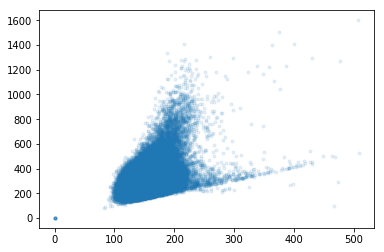

In [82]:
plt.plot(rmse_dki, rmse_dti, '.', alpha=0.1)

In [123]:
idx = (88, 52, 60)

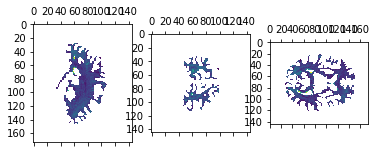

In [124]:
fig, ax = plt.subplots(1, 3)
ax[0].matshow(rmse_dti_map[idx[0]])
ax[1].matshow(rmse_dti_map[:, idx[1]])
ax[2].matshow(rmse_dti_map[:, :, idx[2]])


In [125]:
import seaborn as sns

In [126]:
import pandas as pd

/Users/arokem/.virtualenvs/dki-dipy/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


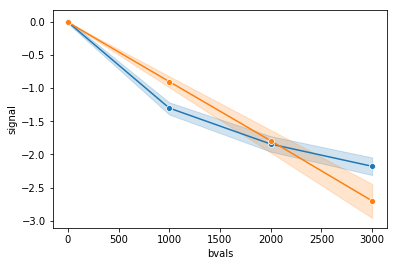

In [154]:
sns.lineplot(x='bvals', y='signal', data=pd.DataFrame(dict(bvals=1000*np.round(gtab.bvals/1000.), 
                                                           signal=np.log(dwi[idx] / b0[idx]))), 
             marker='o')
sns.lineplot(x='bvals', y='signal', data=pd.DataFrame(dict(bvals=1000*np.round(gtab.bvals/1000.), 
                                                           signal=np.log(dti_pred[idx] / b0[idx]))), 
             marker='o')

/Users/arokem/.virtualenvs/dki-dipy/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


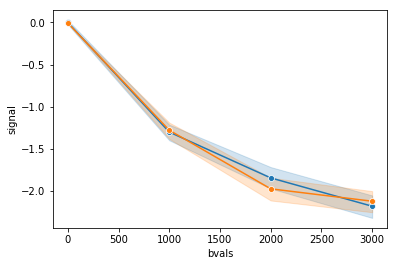

In [155]:
sns.lineplot(x='bvals', y='signal', data=pd.DataFrame(dict(bvals=1000*np.round(gtab.bvals/1000.), 
                                                           signal=np.log(dwi[idx] / b0[idx]))), 
             marker='o')
sns.lineplot(x='bvals', y='signal', data=pd.DataFrame(dict(bvals=1000*np.round(gtab.bvals/1000.), 
                                                           signal=np.log(dki_pred[idx] / b0[idx]))), 
             marker='o')